# 구내식당 식수 인원 예측

### 규제, 릿지회귀, 라쏘회귀, 엘라스틱넷 회귀 연습

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
%matplotlib inline

# 데이터 탐색

### 데이터 설명(출처: 데이콘)
* 일자 (삭제)
* 요일 (삭제)
* 본사정원수 (staff_num)
* 본사휴가자수 (break_num)
* 본사출장자수 (bussinesstrip_num)
* 시간외근무명령서승인건수 (overtime_num)
* 현본사소속재택근무자수 (home_num)
* 조식메뉴 (삭제)
* 중식메뉴 (삭제)
* 석식메뉴 (삭제)
* 중식계 (lunch)
* 석식계 (dinner)

In [2]:
restaurant= pd.read_csv('C:/Users/82102/Desktop/restaurant.csv')
restaurant

,staff_num,break_num,bussinesstrip_num,overtime_num,home_num,lunch,dinner
0,2601,50,150,238,0,1039,331
1,2601,50,173,319,0,867,560
2,2601,56,180,111,0,1017,573
3,2601,104,220,355,0,978,525
4,2601,278,181,34,0,925,330
...,...,...,...,...,...,...,...
1200,2983,75,198,4,391,1093,421
1201,2983,92,231,462,351,832,353
1202,2983,255,248,1,303,579,217
1203,2983,107,153,616,327,1145,502


In [3]:
# 결측값 확인
restaurant.isnull().sum()

staff_num            0
break_num            0
bussinesstrip_num    0
overtime_num         0
home_num             0
lunch                0
dinner               0
dtype: int64

In [4]:
# 전체 직원에서 휴가, 재택 인원을 빼서 실제 먹는 인원 계산
restaurant['eat_num'] = restaurant['staff_num'] - restaurant['break_num'] - restaurant['home_num']

In [5]:
# 비율로 표현
restaurant['dinner_ratio'] = restaurant['dinner'] / restaurant['eat_num']
restaurant['lunch_ratio'] = restaurant['lunch'] / restaurant['eat_num']

In [6]:
features = ['eat_num', 'bussinesstrip_num', 'overtime_num']
labels = ['lunch','dinner','lunch_ratio', 'dinner_ratio']

restaurant = restaurant[features+labels]

In [7]:
restaurant.head()

,eat_num,bussinesstrip_num,overtime_num,lunch,dinner,lunch_ratio,dinner_ratio
0,2551,150,238,1039,331,0.407291,0.129753
1,2551,173,319,867,560,0.339867,0.219522
2,2545,180,111,1017,573,0.399607,0.225147
3,2497,220,355,978,525,0.391670,0.210252
4,2323,181,34,925,330,0.398192,0.142058


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [9]:
# dinner 를 타킷
y_target = restaurant['dinner']
X_data = restaurant.drop(['dinner'],axis = 1, inplace=False)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 릿지 회귀

In [11]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [12]:
# alpha =10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

In [13]:
print ('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores,3))
print ('5 folds의 개별 RMSE scores:', np.round(rmse_scores,3))
print ('5 folds의 평균 RMSEL {0:.3f}'. format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-9487.84  -9563.82  -9947.983 -8962.455 -9028.397]
5 folds의 개별 RMSE scores: [97.406 97.795 99.74  94.67  95.018]
5 folds의 평균 RMSEL 96.926


* 릿지의 5개 폴드 세트의 평균 RMSE는 96.926

### 릿지의 alpha값을 변화시켜 가면서 RMSE와 회귀계수 살피기

In [14]:
# alpha 파라미터 정의
alphas = [0.07,0.1,1,10,100]

In [15]:
for alpha in alphas:
    ridge = Ridge(alpha= alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0.07일 때 5folds의 평균 RMSE: 10.716
alpha 0.1일 때 5folds의 평균 RMSE: 11.720
alpha 1일 때 5folds의 평균 RMSE: 43.719
alpha 10일 때 5folds의 평균 RMSE: 96.926
alpha 100일 때 5folds의 평균 RMSE: 110.897


* alpha가 0.07일 때 가장 좋음

### alpha값의 변화에 따른 피처의 회귀계수 값 시각화

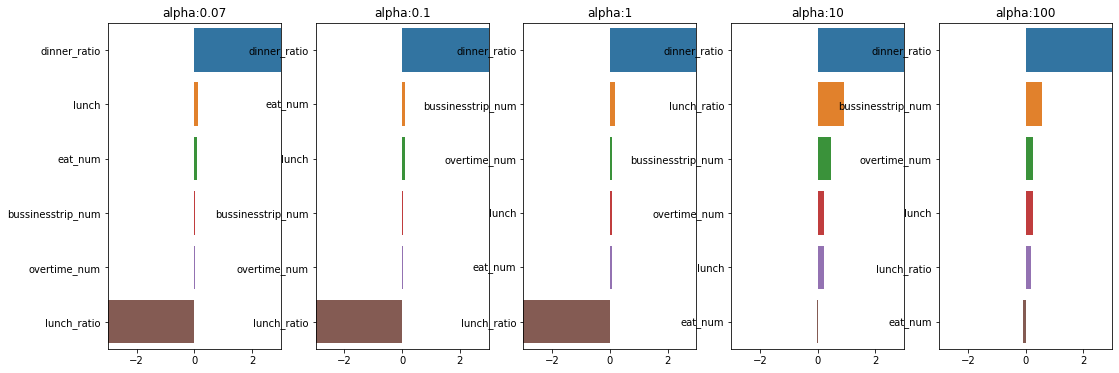

In [16]:
fig, axs = plt.subplots(figsize = (18, 6), nrows=1, ncols =5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_data, y_target)
    
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,3)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])
    
plt.show()

In [17]:
ridge_alphas = [0.07,0.1,1,10,100]
sort_column = 'alpha:'+ str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:1,alpha:10,alpha:100
dinner_ratio,2497.035728,2461.960851,1741.898695,444.552264,52.624448
lunch,0.131722,0.104964,0.085115,0.205395,0.244259
eat_num,0.110318,0.116690,0.080317,-0.034486,-0.069962
bussinesstrip_num,0.017206,0.025791,0.187190,0.473609,0.560021
overtime_num,0.015964,0.019316,0.087665,0.210673,0.247831
lunch_ratio,-332.690569,-254.215354,-18.492914,0.893929,0.174777


* alpha 값이 증가하면서 회귀 계수가 지속적으로 작아져야 하는데 여기서는 그렇지 않음
* 릿지회귀는 회귀계수를 0으로 만들지는 않음

# 라쏘 회귀

In [18]:
from sklearn.linear_model import Lasso, ElasticNet

In [19]:
def get_linear_reg_eval(model_name, params = None, X_data_n = None, y_target_n = None, verbose =True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose : print('###### ', model_name, '######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n,
                                            y_target_n, scoring = "neg_mean_squared_error", cv= 5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
            
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
                
    return coeff_df

In [20]:
lasso_alphas = [0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

######  Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 10.792
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 10.886
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 16.463
alpha 1일 때 5 폴드 세트의 평균 RMSE: 27.580
alpha 3일 때 5 폴드 세트의 평균 RMSE: 77.094


* alpha가 0.07일 때 가장 좋은 평균 RMSE

In [21]:
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column,ascending=True)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
lunch,-0.000295,0.001402,0.024115,0.052507,0.166075
lunch_ratio,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
bussinesstrip_num,0.011927,0.015705,0.066298,0.129538,0.382501
overtime_num,0.012287,0.013931,0.035837,0.063219,0.172750
eat_num,0.154370,0.152809,0.131967,0.105914,0.001702
dinner_ratio,2536.970543,2519.640047,2288.460791,1999.486813,843.590476


* 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음 (lunch_ratio)

# 엘라스틱넷 회귀

In [22]:
# l1_ratio값은 0.7으로 고정
elastic_alphas= [0.07,0.1,0.5,1.3]
coeff_elastic_df= get_linear_reg_eval('ElasticNet', params= elastic_alphas, X_data_n=X_data, y_target_n=y_target)

######  ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 104.400
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 106.786
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 111.550
alpha 1.3일 때 5 폴드 세트의 평균 RMSE: 112.322


* alpha 가 0.07일 때 가장 좋은 성능

In [23]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1.3
dinner_ratio,193.984751,138.300311,27.077029,9.059088
bussinesstrip_num,0.528810,0.541063,0.565178,0.568309
overtime_num,0.234427,0.239705,0.250236,0.251916
lunch,0.230404,0.235883,0.246784,0.248457
lunch_ratio,0.000000,0.000000,0.000000,0.000000
eat_num,-0.057213,-0.062238,-0.072226,-0.073740


### 어떤 것이 좋은지는 상황에 따라 다름 , 각각의 알고리즘에 하이퍼 파라미터를 변경해가면서 최적 예측 성능을 찾아야 함

### 여기서는 RMSE값도 작으면서, lunch_ratio 피처가 제외된 라쏘 회귀가 가장 좋다고 판단
### (라쏘 회귀에서 alpha 0.07일 때 5 폴드 세트의 평균 RMSE가 10.792로 가장 좋다고 판단)